## 该代码在kaggle中使用P100成功运行
### 链接：https://www.kaggle.com/code/czy111/training-my-vqvae-ilsvrc

In [10]:
import torch
from torch import nn
import torch.nn.functional as F
##下采样卷积层
class DownSample(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.main=nn.Conv2d(in_c,in_c,4,2,1)
        self.relu=nn.ReLU()
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.main.weight)
        nn.init.zeros_(self.main.bias)
    def forward(self,x):
        x=self.relu(x)
        return self.main(x)
    
##上采样卷积层
class UpSample(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.main=nn.Conv2d(in_c,in_c,5,1,2)
        self.relu=nn.ReLU()
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.main.weight)
        nn.init.zeros_(self.main.bias)
    def forward(self,x):
        _,_,H,W=x.shape
        x=self.relu(x)
        x=F.interpolate(
            x,scale_factor=2,mode='nearest'
        )
        return self.main(x)

class AttnBlock(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.group_norm=nn.GroupNorm(32,in_c)
        self.proj_q=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_k=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_v=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_out=nn.Conv2d(in_c,in_c,1,1,0)
        self.initialize()
    def initialize(self):
        for layer in [self.proj_q,self.proj_k,self.proj_v,self.proj_out]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.proj_out.weight,gain=1e-5)
    def forward(self,x):
        B,C,H,W=x.shape
        h=self.group_norm(x)
        q=self.proj_q(x)
        k=self.proj_k(x)
        v=self.proj_v(x)
        q=q.permute(0,2,3,1).view(B,H*W,C)
        k=k.view(B,C,H*W)
        w=torch.bmm(q,k)*(int(C)**(-0.5))
        w=F.softmax(w,dim=-1)##(B,H*W,H*W)
        v=v.permute(0,2,3,1).view(B,H*W,C)
        h=torch.bmm(w,v)
        h=h.view(B,H,W,C).permute(0,3,1,2)
        h=self.proj_out(h)
        return x+h
##残差块
class ResBlock(nn.Module):
    def __init__(self,in_c,out_c,dropout,attn=False):
        super().__init__()
        ## block1:调整通道数
        self.block1=nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_c,out_c,3,1,1),
            
        )
        self.block2=nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_c,out_c,1,1,0), 
        )
        
        if in_c!=out_c:
            self.short_cut=nn.Conv2d(in_c,out_c,1,1,0)
        else:
            self.short_cut=nn.Identity()
            
        if attn:
            self.attn=AttnBlock(out_c)
        else:
            self.attn=nn.Identity()
        self.initialize()
    def initialize(self):
        for module in self.modules():
            if isinstance(module,(nn.Conv2d,nn.Linear)):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
        #nn.init.xavier_uniform_(self.block2[-1].weight,gain=1e-5)
    def forward(self,x):
        h=self.block1(x)
        h=self.block2(h)
        h=h+self.short_cut(x)
        return h

##输入图片通道数
input_dim=3

#编码器
class Encoder(nn.Module):
    """
    c:隐藏层通道数
    layer_num:下采样块数，设置为2较好，否则重建图片失真比较严重
    num_res_block:残差块数量
    """
    def __init__(self,c=128,layer_num=2,num_res_block=2,dropout=0.1):
        super().__init__()
        self.head=nn.Sequential(nn.Conv2d(input_dim,c,5,1,2))##增加通道数
        self.down_blocks=nn.ModuleList()
        now_c=c
        for _ in range(layer_num):
            self.down_blocks.append(DownSample(now_c))
        self.down_blocks.append(nn.Conv2d(now_c,now_c,3,1,1))
        for i in range(num_res_block):
            self.down_blocks.append(
                    ResBlock(now_c,now_c,dropout,attn=(i==1))
                )

        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.head[0].weight)
        nn.init.zeros_(self.head[0].bias)
    def forward(self,x):
        h=self.head(x)
        for layer in self.down_blocks:
            h=layer(h)
        return h

## 解码器
class Decoder(nn.Module):
    """
    c:隐藏层通道数
    layer_num:上采样块数，应该和Encoder保持一致
    num_res_block:残差块数量
    """
    def __init__(self,c=128,layer_num=2,num_res_block=2,dropout=0.1):
        super().__init__()
        self.up_blocks=nn.ModuleList()
        now_c=c
        #self.up_blocks.append(nn.Conv2d(now_c,now_c,3,1,1))
        for i in range(num_res_block):
            self.up_blocks.append(
                    ResBlock(now_c,now_c,dropout,attn=(i==1))
                )
        self.up_blocks.append(nn.Conv2d(now_c,now_c,3,1,1))
        for _ in range(layer_num):
            self.up_blocks.append(UpSample(now_c))
           
        self.tail=nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(now_c,input_dim,3,1,1),
        )## 更改输出通道数
        
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.tail[-1].weight)
        nn.init.zeros_(self.tail[-1].bias)
    def forward(self,x):
        h=x
        for layer in self.up_blocks:
            h=layer(h)
        h=self.tail(h)
        return h
    


In [11]:
## VQ层，主要用于学习codebook
class VectorQuantizer(nn.Module):
    def __init__(self, device,num_embeddings, embedding_dim, beta, gamma, decay=0, epsilon=1e-5):
        super().__init__()
        self.e_dim=embedding_dim
        self.n_e=num_embeddings
        self.beta=beta
        self.gamma=gamma
        
        self.embedding=nn.Embedding(num_embeddings,embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / num_embeddings,
                                               1.0 / num_embeddings)
        
        self._ema_cluster_size=torch.zeros(num_embeddings).to(device)
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, embedding_dim))
        self._ema_w.data.normal_()
        self._decay=decay
        self._epsilon=epsilon
    def forward(self,inputs):
        ## B,C,W,H->B,W,H,C
        inputs=inputs.permute(0,2,3,1).contiguous()
        input_shape=inputs.shape
        ## B*W*H,C
        flat_inputs=inputs.view(-1,input_shape[-1])
        ## 计算距离
        ## flat_inputs(B*W*H,d)
        ## embedding(K,d)
        dists=(torch.sum(flat_inputs**2,dim=1,keepdim=True)+
               torch.sum(self.embedding.weight**2,dim=1)-
               2*torch.matmul(flat_inputs,self.embedding.weight.t())
              )
        
        encoding_indices=torch.argmin(dists,dim=1).unsqueeze(1)
        encoding=torch.zeros(encoding_indices.shape[0],self.n_e,device=inputs.device)
        encoding.scatter_(1, encoding_indices, 1)
        ## (B*W*H,K)
        quantized=torch.matmul(encoding.detach(),self.embedding.weight).view(input_shape)
        
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encoding, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self.n_e * self._epsilon) * n) 
            
            dw = torch.matmul(encoding.t(), flat_inputs)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw) 
            
            self.embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1)) # 论文中公式(8)
    
        loss1=F.mse_loss(quantized.detach(),inputs)
        loss2=F.mse_loss(quantized,inputs.detach())
        ## 让z去逼近z_q似乎更好一些，有利于减小codebook weight的方差
        Discrete_loss=self.beta*loss1+self.gamma*loss2
        
        quantized=inputs+(quantized-inputs).detach()
        ## 计算每个向量被使用次数
        avg_probs=torch.mean(encoding,dim=0)
        ## 计算交叉熵
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return Discrete_loss,quantized.permute(0, 3, 1, 2).contiguous(),encoding_indices,perplexity
        

## VQVAE完整模型
class VQVAE(nn.Module):
    def __init__(self,device,hidden_dim,num_embeddings, embedding_dim,  beta, gamma,dropout=0.1,decay=0):
        super().__init__()
        layer_num=2
        self.layer_num=layer_num
        self.encoder=Encoder(c=hidden_dim,layer_num=layer_num,num_res_block=2,dropout=dropout)
        self.decoder = Decoder(c=hidden_dim,layer_num=layer_num,num_res_block=2,dropout=dropout)
        self.pre_vq_conv = nn.Sequential(nn.Conv2d(hidden_dim, embedding_dim,1, 1,0))
        self.aft_vq_conv = nn.Sequential(nn.Conv2d(embedding_dim,hidden_dim,1, 1,0))
        self.quantize = VectorQuantizer(device,num_embeddings, embedding_dim,
                                       beta,gamma,decay)
        
    def forward(self,x):
        z=self.encoder(x)
        z=self.pre_vq_conv(z)
        loss,quantized,avgprobs,perplexity=self.quantize(z)
        #print(quantized.shape)
        quantized=self.aft_vq_conv(quantized)
        x_recon=self.decoder(quantized)
        return loss,x_recon,perplexity

    ## 从z_q得到重建图像
    def decode(self,quantized):
        quantized=self.aft_vq_conv(quantized)
        x_recon=self.decoder(quantized)
        return x_recon   
    
    ## 从输入图像得到z_q
    def encode(self,x):
        z=self.encoder(x)
        z=self.pre_vq_conv(z)
        loss,quantized,avgprobs,perplexity=self.quantize(z)
        #z=self.aft_vq_conv(quantized)
        
        return quantized,None
        

## 数据集来源
### https://www.kaggle.com/datasets/hmendonca/imagenet-1k-tfrecords-ilsvrc2012-part-0
### https://www.kaggle.com/datasets/hmendonca/imagenet-1k-tfrecords-ilsvrc2012-part-1

## 数据集大小：约140GB，超过一百万张图片

In [4]:
## 数据准备
from torch.utils.data import DataLoader
import os.path as osp
from glob import glob
import random
def make_datapath_list(root_path):
    target_path=osp.join(root_path+'/**/*1024')
    return glob.glob(target_path)

train_path1='/kaggle/input/imagenet-1k-tfrecords-ilsvrc2012-part-0/train/*1024'
train_path2='/kaggle/input/imagenet-1k-tfrecords-ilsvrc2012-part-0/train/*1024'
val_path='/kaggle/input/imagenet-1k-tfrecords-ilsvrc2012-part-0/validation/*128'
train_list=glob(train_path1)+glob(train_path2)
val_list=glob(val_path)
len(train_list),len(val_list)

(1000, 128)

In [19]:
## 数据的格式为TF-record,需要转成pytorch dataloader
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')  
image_shape = (128,128)
def decode(serialized_example):
    features = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        })
    image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
    image = tf.image.resize_with_pad(image, *image_shape)  # crop/augment instead
    label = tf.cast(features['image/class/label'], tf.int64) - 1  # [0-999]
    return image
def create_datasets(tfrecords):
    dataset = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(decode, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.as_numpy_iterator()
    return dataset

In [32]:
%%time
#创建Dataset
from torch.utils import data
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImagenetDataset(data.Dataset):  
    def __init__(self, tfrecords_files,transform=None,data_type='train'):  
        self.tf_dataset=create_datasets(tfrecords_files)
        self.data_type=data_type
        self.transform=transform
    def __len__(self):  
        if self.data_type=='val':
            return 128*100
        return 1024*1024
  
    def __getitem__(self, idx):
        imgs=next(self.tf_dataset)
        imgs=Image.fromarray(imgs.astype(np.uint8),mode='RGB')
        img_tranformed=self.transform(imgs)
        return img_tranformed

    
img_size=image_shape[0]
mean=(0.5,0.5,0.5)
std=(0.5,0.5,0.5)
transform = transforms.Compose([
                               transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                                transforms.Normalize(mean,std)
])
train_dataset=ImagenetDataset(tfrecords_files=train_list,transform=transform,data_type='train')
val_dataset=ImagenetDataset(tfrecords_files=val_list,transform=transform,data_type='val')

batch_size=16
#创建DataLoader
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
                                             shuffle=True,drop_last=True,num_workers=0)
val_dataloader=torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

val_iter=iter(val_dataloader)
dataloaders_dict={
    'train':train_dataloader,
}

batch_iter=iter(dataloaders_dict['train'])#转成迭代器
inputs=next(batch_iter)#取第一个元素
print(inputs.size())

def get_infinite_data(dataloader):
    while True:
        for image in dataloader:
            yield image
train_generator=get_infinite_data(train_dataloader)
def get_batch():
    return train_generator.__next__()  

data_variance=torch.Tensor([0.5]).to(device)
print(data_variance)

torch.Size([16, 3, 128, 128])
tensor([0.5000], device='cuda:0')
CPU times: user 16.1 s, sys: 556 ms, total: 16.7 s
Wall time: 5.36 s


In [25]:
from scipy.signal import savgol_filter
import umap
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128" 


## 显示测试结果
def show(img, save_img = None):
    npimg = img.numpy()
    fig = plt.figure(figsize=(16,8))
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.savefig(save_img)
    plt.show()

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return x_q
def decode_img(model,z):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    #print(z_q[0,:1])
    return model.decode(z).add(1).div(2).clamp(0,1)

@torch.no_grad()
def test():
    f=4
    e_dim = model.quantize.e_dim
    toksX, toksY = 128 // f, 128 // f
    sideX, sideY = toksX * f, toksY * f
    n_toks = model.quantize.n_e
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    z.mean(),torch.mean(torch.abs(z))
    out=decode_img(model,z)
    show(out[0].detach().cpu(),'1.png')

## 验证
@torch.no_grad()
def eval():
    model.eval()
    sample_num=8
    valid_originals = next(val_iter)
    valid_originals = valid_originals[:sample_num].to(device)
    if hasattr(torch.cuda, 'empty_cache'):
           torch.cuda.empty_cache()
    _,valid_reconstructions,_=model(valid_originals)
    tensor_std=torch.Tensor(std).to(device).view(1,3,1,1).repeat(sample_num,1,img_size,img_size)
    tensor_mean=torch.Tensor(mean).to(device).view(1,3,1,1).repeat(sample_num,1,img_size,img_size)
    show(make_grid((valid_reconstructions*tensor_std+tensor_mean).cpu().data), 'reconstructions.png') # 展示重建图像
    show(make_grid((valid_originals*tensor_std+tensor_mean).cpu()), 'originals.png') # 展示源图像

    # 绘制embedding space
    proj = umap.UMAP(n_neighbors = 3, min_dist = 0.1,
                metric='cosine').fit_transform(model.quantize.embedding.weight.data.cpu())
    fig = plt.figure(figsize=(16, 8))
    plt.scatter(proj[:,0], proj[:,1], alpha=0.3)
    plt.savefig("Embedding.png")
    plt.show()
    test()
    model.train()

In [34]:
## 设置训练参数
lr =5e-6
device_ids="cuda" if torch.cuda.is_available() else "cpu"
device=torch.device(device_ids)

vqvae_config={
    'device':device_ids,
    'hidden_dim':256,
    'num_embeddings':16384,
    'embedding_dim':256,
    'beta':1,
    'gamma':0.25,
    'decay':0.99,
    'dropout':0.3,
}
model=VQVAE(**vqvae_config).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [35]:
from tqdm import tqdm

## 设置两个loss权重
disc_weight=0.75
codebook_weight=1.0

train_res_recon_error = []
train_res_perplexity = []
train_res_vq_loss=[]
batches=62500
## 开始训练
model.train()
with tqdm(total=batches//20, unit='batch',mininterval=3) as pbar:
    for i in range(batches):
        data=get_batch()
        data = data.to(device)
        optimizer.zero_grad()
        
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        vq_loss, data_recon, perplexity = model(data)
        recon_error = F.mse_loss(data_recon, data) / data_variance # 计算源图像和重建图像的重建损失
        loss = recon_error*disc_weight+ vq_loss*codebook_weight
        #print(recon_error.item(),vq_loss.item())
        
        loss.backward()
        optimizer.step()

        #print(recon_error)
        train_res_recon_error.append(recon_error.item()) # 记录重建损失
        train_res_perplexity.append(perplexity.item())
        train_res_vq_loss.append(vq_loss.item())
        if i % 20 == 0:
            pbar.set_postfix({
                'recon_error': f'{  np.mean(train_res_recon_error[-20:]):.4f}',
                'perplexity':f'{np.mean(train_res_perplexity[-20:]):.4f}',
                'vq_loss':f'{np.mean(train_res_vq_loss[-20:]):.4f}',
                             })
            pbar.update(1)
        if (i+1) % 1500==0:
            train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
            train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

            f = plt.figure(figsize=(16,8))
            ax = f.add_subplot(1,2,1)
            ax.plot(train_res_recon_error_smooth)
            ax.set_yscale('log')
            ax.set_title('Smoothed NMSE.')
            ax.set_xlabel('iteration')
            ax = f.add_subplot(1,2,2)
            ax.plot(train_res_perplexity_smooth)
            ax.set_title('Smoothed Average codebook usage (perplexity).')
            ax.set_xlabel('iteration')
            plt.savefig('metric.png')
            eval()      
        if i%2000==0:
            torch.save(model.state_dict(), f'vqvae{i}.pkl')

100%|██████████| 3125/3125 [6:46:27<00:00,  7.80s/batch, recon_error=0.0304, perplexity=278.4944, vq_loss=0.0053]


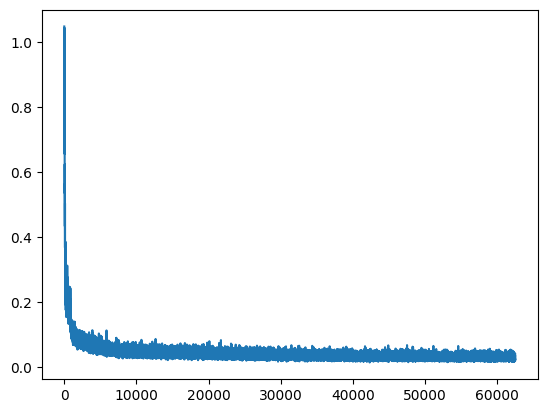

In [37]:
plt.plot(range(len(train_res_recon_error)),train_res_recon_error)

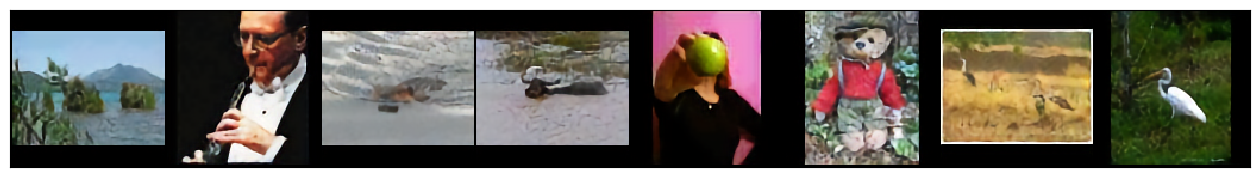

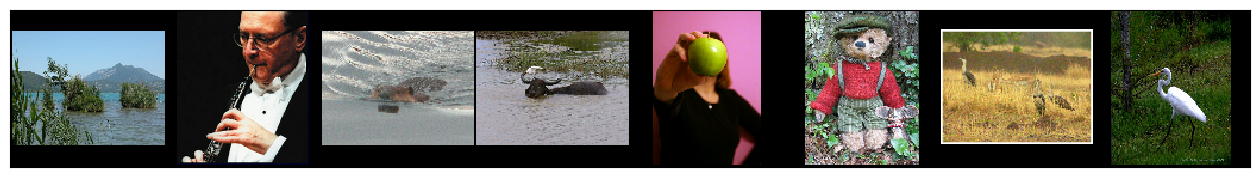

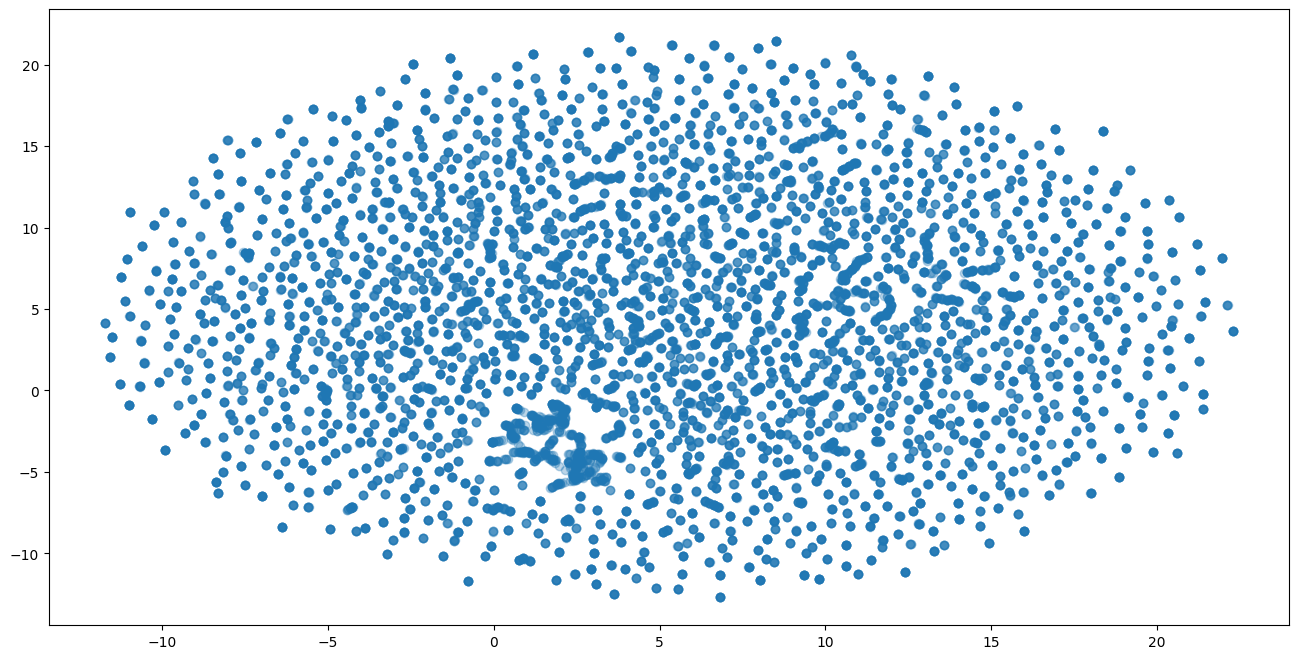

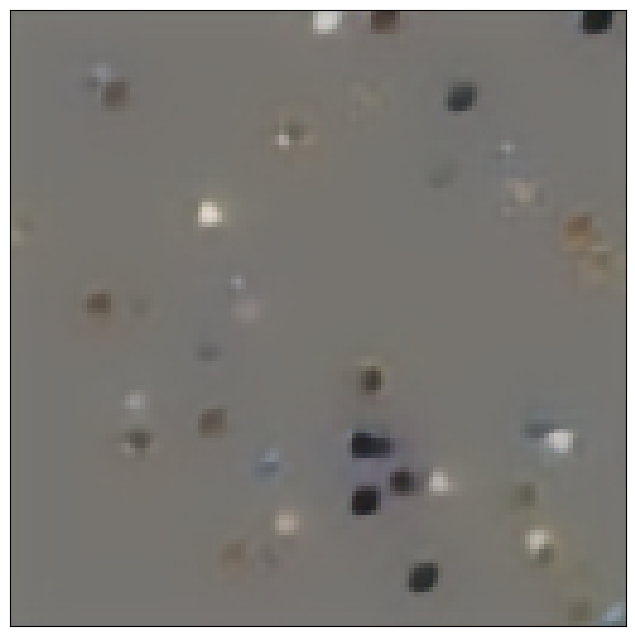

In [38]:
eval()

## 保存模型及配置文件

In [39]:
import ruamel.yaml
vqvae_config={
    'device':device_ids,
    'hidden_dim':256,
    'num_embeddings':16384,
    'embedding_dim':256,
    'beta':1,
    'gamma':0.25,
    'decay':0.99,
    'dropout':0.3,
}
def createYaml(file, data: dict):
    with open(file, 'w', encoding='utf-8') as f:
        writer = ruamel.yaml.YAML()
        writer.indent(mapping=2, sequence=4, offset=2)
        writer.dump(data, f)

createYaml('vqvae_16384.yaml',vqvae_config)
torch.save(model.state_dict(), f'vqvae_16384.pkl')

## 将配置文件和模型上传到kaggle

In [42]:
import  os
import shutil
import json
##将文件移到同一目录
def move_files(file_path_list,target_dir):
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    for file_path in file_path_list:
        shutil.move(file_path,target_dir)

## 准备上传文件所需数据
def prepare_dataset_metadata(
        user_name,
        key,
        dataset_name,
        file_path_list,
        target_dir
):
    
    if not os.path.exists('/root/.kaggle/'):
        os.mkdir('/root/.kaggle')
    os.chdir('/root/.kaggle')
    
    kaggle_json={
        "username":user_name,
        "key":key
    }
    
    print(kaggle_json)
    with open('kaggle.json', 'w', encoding='utf-8') as f:
        json.dump(kaggle_json, f, ensure_ascii=False, indent=0)
    
    os.chdir('/kaggle/working')
    try:
        move_files(file_path_list,target_dir)
    except:
        pass
    
    os.chdir(target_dir)
    metadata={
        "title":dataset_name,
        "id": f"{user_name}/{dataset_name}", 
        "licenses": [{"name": "CC0-1.0"}]
    }
    print(metadata)
    
    with open('dataset-metadata.json', 'w', encoding='utf-8') as f:
        json.dump(metadata, f, ensure_ascii=False, indent=0)
    print('create dataset-metadata.json successful!')


config={
    'user_name':'czy111',
    'key':'766f9c41fcaf58b1538eea7f8778e0d7',
    'dataset_name':'vqvae-16384',
    'file_path_list':['/kaggle/working/vqvae_16384.pkl','/kaggle/working/vqvae_16384.yaml'],
    'target_dir':'./model',
}   
prepare_dataset_metadata(**config)

{'username': 'czy111', 'key': '766f9c41fcaf58b1538eea7f8778e0d7'}
{'title': 'vqvae-16384', 'id': 'czy111/vqvae-16384', 'licenses': [{'name': 'CC0-1.0'}]}
create dataset-metadata.json successful!


In [43]:
!kaggle datasets create -p /kaggle/working/model -u

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Starting upload for file vqvae_16384.pkl
100%|██████████████████████████████████████| 69.7M/69.7M [00:04<00:00, 18.1MB/s]
Upload successful: vqvae_16384.pkl (70MB)
Starting upload for file vqvae_16384.yaml
100%|████████████████████████████████████████████| 115/115 [00:00<00:00, 151B/s]
Upload successful: vqvae_16384.yaml (115B)
Your public Dataset is being created. Please check progress at https://www.kaggle.com/datasets/czy111/vqvae-16384
